Converged at iteration 9!
Converged at iteration 26308!
Converged at iteration 11495!


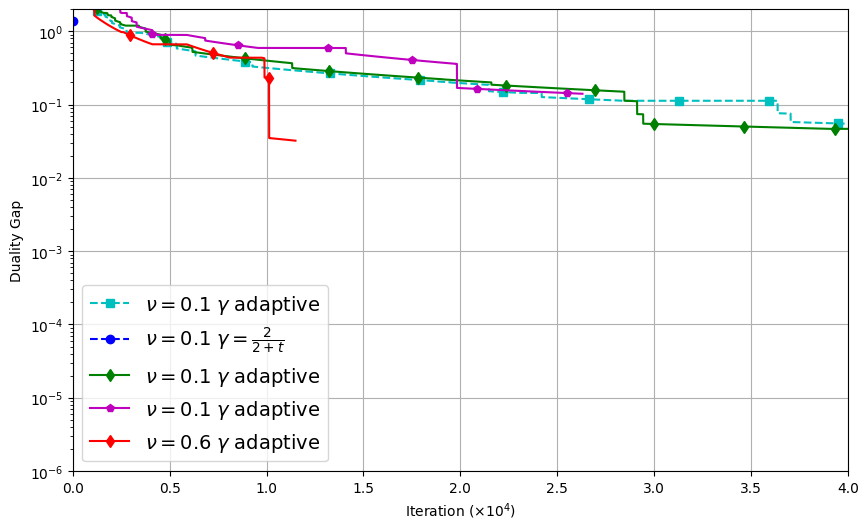

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

def metaF(x, y, M, a, b, mu): #For the FW method you will notice we only require access to the gradient
    #this is R(t), and can be considered step 1 of constructing the LMO
    part1 = mu * (x - a) - np.dot(M, (y - b))
    part2 = np.dot(M.T, (x - a)) + mu * (y - b)

    return np.concatenate([part1, part2])#this is the gradient


def F(x, y, M, a, b, mu):#this just makes it so we can call F on its own
    #they do this in the paper, so we are doing it here
    return metaF(x, y, M, a, b, mu)

def S(F): #this is the FW corner function
    #solves the solution argmin z.T(metaF)
    #was confusing to me, but given the fact that the X and Y are [0,1]^d matrices
    #what we have is Well dxL = x. And dyL = y from xTy
    #[LMOx = -0.5(sign(x) - 1),
    #LMOy = -0.5(sign(y) - 1)]

    return -(np.sign(F + np.finfo(float).eps) - 1) * 0.5

def SP_FW(Kmax, mu, M, cst, dim, a, b, away, adaptive, tau):
    samples = {
        "gaps" : [],
        "iterations" :[]
    }
    safety = 0

    # Define the problem constants
    delta = min(np.linalg.norm(np.minimum(1 - a, a), 2), np.linalg.norm(np.minimum(1 - b, b), 2))
    #here we choose min(a or 1-a). Norm of that, do that for a and b, and min of that
    #this is *root(min(np.minimum(a))) so its the border distance, square and square rooted (i.e norm), the minimum of both is the delta
    #this is constant
    Pwidth = 1 / np.sqrt(dim)#this is d, dim, just the general length of X and Y
    diam = np.sqrt(dim)
    C_L = mu * diam ** 2
    mu_A = mu * Pwidth ** 2
    mu_int = mu * delta ** 2
    M_L = np.sqrt(2 / mu) * np.linalg.norm(M) * diam


    #tau = 1 - M_L / mu_int

    # Determine the correct C based on the adaptive strategy
    #if adaptive == 4:
    #    C = 2 * mu * diam ** 2 + np.linalg.norm(M) ** 2 * (diam ** 2 / mu + diam ** 2 / mu)
    #else:
    C = 2 * mu * diam ** 2 / tau

    gamma_coef = 1 / C if adaptive > 0 else None

    # Initialize variables
    x_0 = np.concatenate([np.ones(dim), np.zeros(dim)])
    S_0 = x_0
    alpha_0 = 1
    iter = 1
    tol = 1e-6
    G = []

    z = x_0
    S_t = S_0
    alpha_t = alpha_0
    gap_best = np.inf

    for k in range(Kmax):
        Fz = F(z[:dim], z[dim:], M, a, b, mu)
        Sz = S(Fz)
        s_FW = Sz
        grad = Fz
        s_FW = np.mean(s_FW, axis=1)  # Correcting to (60,)
        #print(s_FW)
        #print(z)
        d_FW = s_FW - z

        gap = -np.dot(d_FW, grad)
        #print(gap)
        #print(gap_best)
        gap_best = min(gap[0], gap_best)
        G.append(gap_best)

        if gap[0] < tol:
            print(f'Converged at iteration {iter}!')
            break


        # Adjust steps based on algorithm variant
        if adaptive == 3:
            step = 2 / (2 + iter)
        else:
            step = min(1, gamma_coef * gap[0]) if adaptive > 0 else 1

        # Update position
        z += step * d_FW
        iter += 1
        samples["gaps"].append(math.log10(gap[0]))
        samples["iterations"].append(k)

    return np.array(G), iter, tau


# Seed for reproducibility
np.random.seed(2)

# Initialization
fEvals = []
fVals = []
Kappas = []
strongs = [11, 12, 21, 40]  # The different values of strong convexity
taus = [.1,.1,.14,.63]
cst = 0.1
dim = 30
a = np.random.rand(dim, 1) / 2 + 0.25 #inside the domain X x Y
b = np.random.rand(dim, 1) / 2 + 0.25 #inside the domain X x Y
M = cst * (2 * np.random.rand(dim, dim) - 1)
Kmax = 40000
away = 0 #1a is specifically SP-FW on Problem I

for i in range(4):
    adaptive = 1
    strong = strongs[i]
    G, niter, kappa= SP_FW(Kmax, strong, M, cst, dim, a, b, away, adaptive,taus[i])
    fEvals.append(np.arange(1, niter) / 10000)
    fVals.append(G[:niter-1])
    Kappas.append(f'$\\nu = {kappa:.1f} \\;\\gamma$ adaptive')

    if i == 0:
        adaptive = 3
        G, niter, kappa = SP_FW(Kmax, strong, M, cst, dim, a, b, away, adaptive,taus[i])
        fEvals.append(np.arange(1, niter) / 10000)
        fVals.append(G[:niter-1])
        Kappas.append(f'$\\nu = {kappa:.1f} \\;\\gamma = \\frac{{2}}{{2+t}}$')

# Plotting setup
colors = ['c', 'b', 'g', 'm', 'r']
line_styles = ['--', '--', '-', '-', '-']
markers = ['s', 'o', 'd', 'p', 'd']

plt.figure(figsize=(10, 6))
for idx, (evals, vals) in enumerate(zip(fEvals, fVals)):
    plt.plot(evals, vals, label=Kappas[idx], color=colors[idx % len(colors)],
             linestyle=line_styles[idx % len(line_styles)], marker=markers[idx % len(markers)],
             markevery=(0.1, 0.1))

plt.xlabel('Iteration ($\\times 10^4$)')
plt.ylabel('Duality Gap')
plt.yscale('log')
plt.xlim([0, Kmax / 10000])
plt.ylim([1e-6, 2])
plt.legend(fontsize=14)
plt.grid(True)
plt.show()